## Assignment 1


In [1]:
import time
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
%matplotlib inline

## setting the parameters 

In [2]:
device = torch.device('cuda:0')


# Load the true model for forward modelling 
path = './'
velocity_file= path + 'Marm.bin' # true model 

# Define the model and achuisition parameters
par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':221,   'dz':0.015, 'oz':0,
       'ns':30,    'ds':0.3,   'osou':0,  'sz':0,
       'nr':300,   'dr':0.03,  'orec':0, 'rz':0,
       'nt':4000,  'dt':0.001,  'ot':0,
       'freq':15,
       'num_batches':5, # increase thus number if you have a CUDA out of memory error 
        'FWI_itr': 100
      }

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]
    
fs = 1/dt # sampling frequency


# Don't change the below two lines 
num_sources_per_shot=1
num_dims = 2 



## The acquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [3]:

x_s = torch.zeros(ns, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(ns).float() * ds  
x_s[:, 0, 0] = sz

x_r = torch.zeros(ns, nr, num_dims)
x_r[0, :, 1] = torch.arange(nr).float() * dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(ns, 1)
x_r[:, :, 0] = rz





## Create source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use any function to create the wavelet but it needs to be converted to tensor. 

torch.Size([4000, 30, 1])


Text(0.5, 0, 'Time (s)')

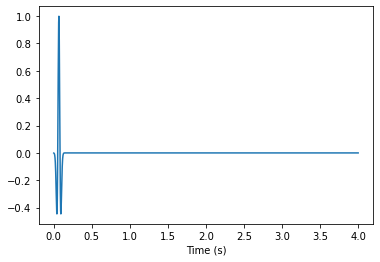

In [4]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, ns, num_sources_per_shot))
print(source_wavelet.shape)


plt.plot(np.arange(0,nt)*dt,source_wavelet[:,0,0])
plt.xlabel('Time (s)')

### Load the velocity model 
Note: We often do not update the water layer, thus we will keep it untouched by masking the gradient in this region. 

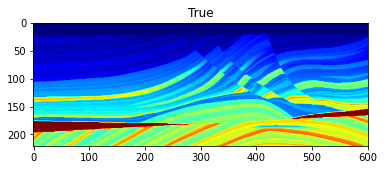

In [5]:
# function to get water layer mask
def mask(m):
    water_velocity= 1.5 # km/s
    msk = np.ones_like(m) 
    for i in range(m.shape[0]):
        for j in range (m.shape[1]): 
            msk[i,j] = (0 if m[i,j] <= water_velocity else 1)    
    return msk 


# Load the true model
model_true = (np.fromfile(velocity_file, np.float32)
              .reshape(nz, nx))

msk = mask(model_true) # get the mask for the water layer 

model_true = torch.Tensor(model_true) 
msk = torch.Tensor(msk)



m_vmin, m_vmax = np.percentile(model_true.numpy(), [2,98]) 
plt.imshow(model_true, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');

## Forward modeling 

In [6]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

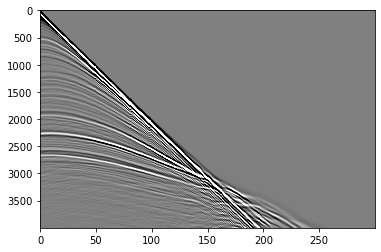

In [7]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,0].cpu().numpy(), [2,98])

plt.imshow(data_true[:,0,].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



## Create initial model for FWI 

### Task 1:  test different initial model (i.e. different smoothing) and observe the convergence. 

/tmp/ipykernel_23052/3931296972.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_init = torch.tensor(model_init)


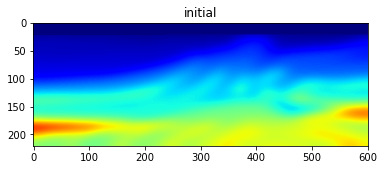

In [8]:
# Create initial guess model for inversion by smoothing the true model
# model_init = # To do 

model_init = gaussian_filter(model_true.cpu().detach().numpy(),
                                           sigma=[10,15])

model_init = torch.Tensor(model_init) 
model_init = model_init * msk  # to preserve the water layer  
model_init[model_init==0] = 1.5 # km/s


model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

# plot the initial model 
plt.imshow(model_init, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('initial');

##  Set the optimizer and the criterion 

### Task 2:  test different optimizer and observe the convergence. 

In [9]:
criterion = torch.nn.MSELoss()
# optimizer = # To do

optimizer = torch.optim.Adam([{'params': [model], 'lr': 0.01}])

## Filter the low frequencies from the observed data/wavelet   
### Task 3:  Filter frequency below 5 Hz and see how this affects the convergence. You may want to test this with different initial model like in the first task you used in the first task
(hint: you can use the below functions to filter the data or whatever function you want) 
The below functions are only applies for 1D which means you need to filter the data trace by trace (becarefule with the shapes).

In [10]:
# def butter_bandpass(lowcut, highcut, fs,btype ,order=7):
#     nyq = 0.5 * fs
#     if lowcut != None: low = lowcut / nyq
#     if highcut != None: high = highcut / nyq

#     if btype == 'band': b, a = signal.butter(order, [low, high], btype=btype, analog=False)
#     if btype == 'low':  b, a = signal.butter(order, high, btype=btype, analog=False)
#     if btype == 'high': b, a = signal.butter(order,low, btype=btype, analog=False)
    
#     return b, a        

# def butter_bandpass_filter(data,lowcut=None,highcut=None,fs=None,btype='band',order=7):
#     """
#     This functions create a butterworth filter and apply the bandpass/high_cut/low_cut filters to the data  

#     Arguments:
#     ----------
#             data   :     1D array that will be filtered 
#             lowcut :   The lower band of frequency  [None for law_pass_filter] 
#             highcut:  The high band of frequency  [None for high_pass filter]
#             btype  :  filtertype ['band','low','high']
#             order  :  order of the butterworth filter 
#     for more details - check the scipy documentation 
#     """
#     b, a = butter_bandpass(lowcut, highcut, fs,btype, order=order)
#     y = signal.filtfilt(b, a, data)
#     return y 



# # To do: filter the wavelet and the data 
# # 
# #     


## Main inversion loop 

Epoch: 0 Loss:  2.4321027098728534e-13


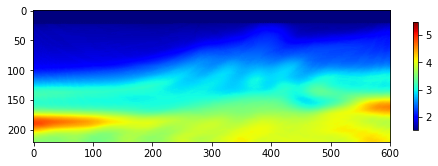

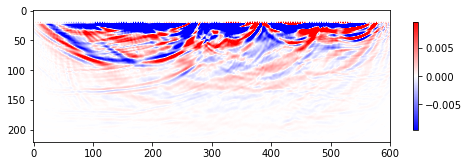

Epoch: 1 Loss:  2.2184528113188343e-13
Epoch: 2 Loss:  2.0614912026235312e-13
Epoch: 3 Loss:  1.9489864908593668e-13
Epoch: 4 Loss:  1.8629068692386022e-13
Epoch: 5 Loss:  1.7917179004833198e-13
Epoch: 6 Loss:  1.7312559602599732e-13
Epoch: 7 Loss:  1.6805531948417118e-13
Epoch: 8 Loss:  1.6393103305476116e-13
Epoch: 9 Loss:  1.606433610673542e-13
Epoch: 10 Loss:  1.5799180574113756e-13


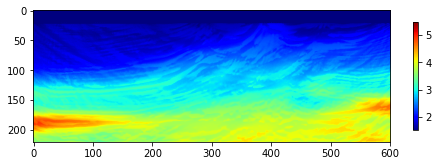

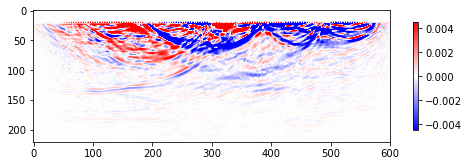

Epoch: 11 Loss:  1.5572119840075085e-13
Epoch: 12 Loss:  1.5366292358551595e-13
Epoch: 13 Loss:  1.5172172058205285e-13
Epoch: 14 Loss:  1.4981549495711368e-13
Epoch: 15 Loss:  1.478175254995915e-13
Epoch: 16 Loss:  1.4578399082268e-13
Epoch: 17 Loss:  1.4377703942778514e-13
Epoch: 18 Loss:  1.418684912385046e-13
Epoch: 19 Loss:  1.401107970760312e-13
Epoch: 20 Loss:  1.3852953733537203e-13


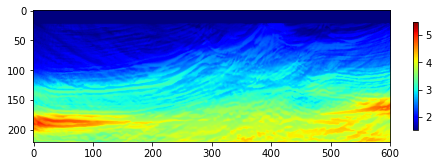

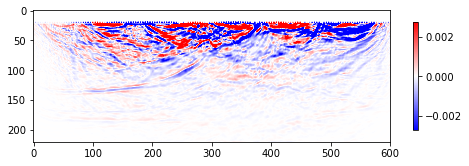

Epoch: 21 Loss:  1.3713669075646716e-13
Epoch: 22 Loss:  1.3591569191596714e-13
Epoch: 23 Loss:  1.348300497874713e-13
Epoch: 24 Loss:  1.3376925367641727e-13
Epoch: 25 Loss:  1.32638380835571e-13
Epoch: 26 Loss:  1.314096172440435e-13
Epoch: 27 Loss:  1.3015629732034215e-13
Epoch: 28 Loss:  1.2897259672864153e-13
Epoch: 29 Loss:  1.2789396295075127e-13
Epoch: 30 Loss:  1.2691768209310839e-13


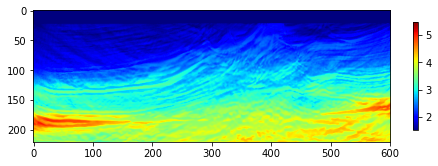

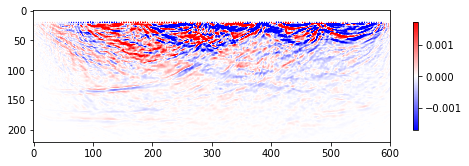

Epoch: 31 Loss:  1.2599531488255824e-13
Epoch: 32 Loss:  1.2511221866054164e-13
Epoch: 33 Loss:  1.2422704720780426e-13
Epoch: 34 Loss:  1.2333114215355928e-13
Epoch: 35 Loss:  1.2240456603629423e-13
Epoch: 36 Loss:  1.21469786404935e-13
Epoch: 37 Loss:  1.2053516432170399e-13
Epoch: 38 Loss:  1.1965023681445542e-13
Epoch: 39 Loss:  1.1884965938919329e-13
Epoch: 40 Loss:  1.181071257436747e-13


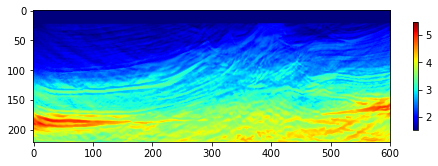

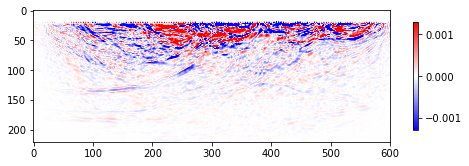

Epoch: 41 Loss:  1.1737377732343613e-13
Epoch: 42 Loss:  1.16590334527664e-13
Epoch: 43 Loss:  1.1575439432388694e-13
Epoch: 44 Loss:  1.1492205146903687e-13
Epoch: 45 Loss:  1.14129611489299e-13
Epoch: 46 Loss:  1.1337715485280333e-13
Epoch: 47 Loss:  1.1265014223901023e-13
Epoch: 48 Loss:  1.119192502143187e-13
Epoch: 49 Loss:  1.1118636681516818e-13
Epoch: 50 Loss:  1.1046175553978054e-13


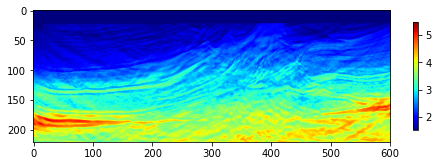

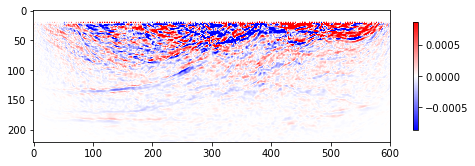

Epoch: 51 Loss:  1.097437862732488e-13
Epoch: 52 Loss:  1.0901075591388193e-13
Epoch: 53 Loss:  1.0828528744115168e-13
Epoch: 54 Loss:  1.0758758852008068e-13
Epoch: 55 Loss:  1.0692729415044395e-13
Epoch: 56 Loss:  1.062846553355598e-13
Epoch: 57 Loss:  1.0563339753692086e-13
Epoch: 58 Loss:  1.0499155281542476e-13
Epoch: 59 Loss:  1.0437907260862759e-13
Epoch: 60 Loss:  1.0380653212287583e-13


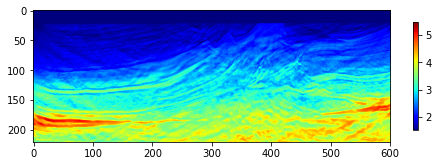

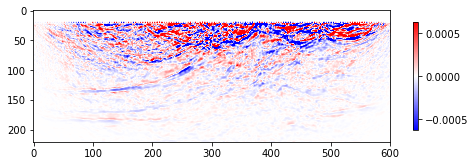

Epoch: 61 Loss:  1.0325368176501595e-13
Epoch: 62 Loss:  1.0271230531545958e-13
Epoch: 63 Loss:  1.0218594210137681e-13
Epoch: 64 Loss:  1.0167335714873055e-13
Epoch: 65 Loss:  1.0116237690000287e-13
Epoch: 66 Loss:  1.0063167518316427e-13
Epoch: 67 Loss:  1.0008936911494828e-13
Epoch: 68 Loss:  9.955220919540334e-14
Epoch: 69 Loss:  9.902162648669382e-14
Epoch: 70 Loss:  9.848488288384245e-14


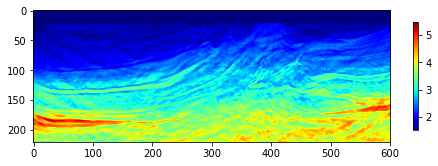

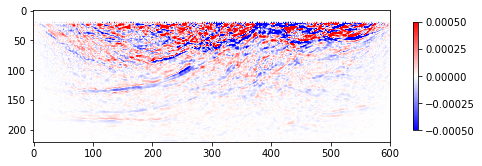

Epoch: 71 Loss:  9.794780216187808e-14
Epoch: 72 Loss:  9.742149146383804e-14
Epoch: 73 Loss:  9.690256985771337e-14
Epoch: 74 Loss:  9.63862257728472e-14
Epoch: 75 Loss:  9.586467624700368e-14
Epoch: 76 Loss:  9.534582028593243e-14
Epoch: 77 Loss:  9.484701952395332e-14
Epoch: 78 Loss:  9.434703799804573e-14
Epoch: 79 Loss:  9.384186797181974e-14
Epoch: 80 Loss:  9.333971338288598e-14


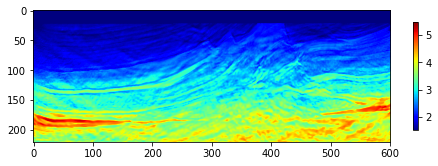

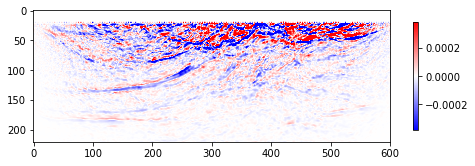

Epoch: 81 Loss:  9.284552767991998e-14
Epoch: 82 Loss:  9.236103288090352e-14
Epoch: 83 Loss:  9.187486222720091e-14
Epoch: 84 Loss:  9.140525996146308e-14
Epoch: 85 Loss:  9.094286298149106e-14
Epoch: 86 Loss:  9.047726675807726e-14
Epoch: 87 Loss:  9.00072248822398e-14
Epoch: 88 Loss:  8.954761421714778e-14
Epoch: 89 Loss:  8.910401586289065e-14
Epoch: 90 Loss:  8.866552384675605e-14


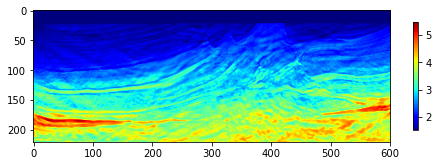

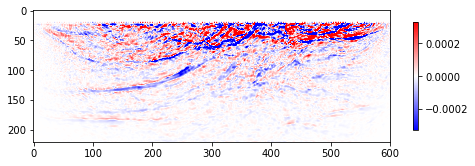

Epoch: 91 Loss:  8.822367249795263e-14
Epoch: 92 Loss:  8.778328228098323e-14
Epoch: 93 Loss:  8.734815679729748e-14
Epoch: 94 Loss:  8.691377119689116e-14
Epoch: 95 Loss:  8.648228626081272e-14
Epoch: 96 Loss:  8.605506062990954e-14
Epoch: 97 Loss:  8.563561796124221e-14
Epoch: 98 Loss:  8.521253728606642e-14
Epoch: 99 Loss:  8.479072080756441e-14
Runtime: 6.526058650016784 minutes


In [11]:
# Iterative inversion loop
num_shots_per_batch = int(ns / num_batches)
msk = msk.to(device)
epoch_loss = []
updates = []
gradients = []



t_start = time.time()
for epoch in range(FWI_itr):
  running_loss=0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
    batch_data_true = data_true[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
    loss = criterion(data_pred, batch_data_true)
    running_loss += loss.item()
    loss.backward()
  epoch_loss.append(running_loss)     

  # Apply some operations to the gradient
  if epoch==0: gmax = torch.abs(model.grad).max()
  model.grad = model.grad / gmax  * msk  # normalizing by the first gradient and mask the wter layer
    

  # update the model 
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)

  # save the model updates and gradients for each iteration
  updates.append(model.detach().clone().cpu().numpy())
  gradients.append(model.grad.cpu().detach().numpy())  
    
  # plotting every 10 itr   
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax,
               cmap='jet')
    plt.colorbar(shrink=0.5)
    
    plt.figure(figsize=(8, 4))
    gr = model.grad.cpu().detach().numpy()
    g_min, g_max = np.percentile(gr, [2,98]) 
    plt.imshow(gr, cmap='bwr',vmin=-g_max,vmax=g_max)
    plt.colorbar(shrink=0.5)
    plt.show()
    
t_end = time.time()
print('Runtime:', (t_end - t_start)/60 ,'minutes')

## Plot the convergence curve and the final inversion results 

In [12]:
updates = np.array(updates)
gradients = np.array(gradients)
obj = np.array(epoch_loss)


Text(0.5, 0, 'iteration#')

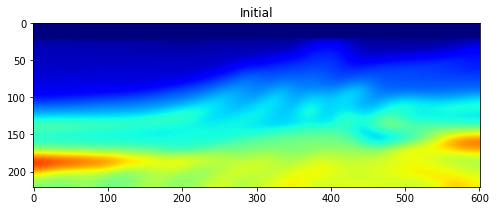

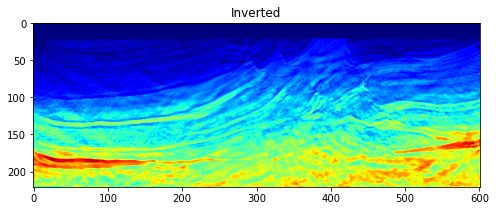

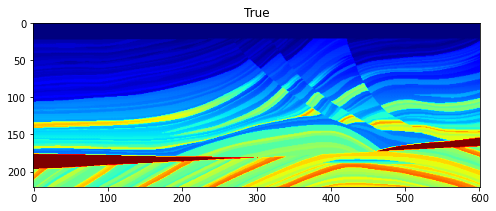

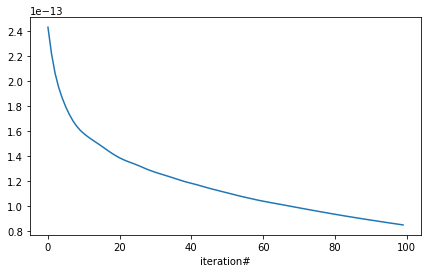

In [14]:
# Plot initial, inverted, and true models
figsize = (8, 4)
plt.figure(figsize=figsize)
plt.imshow(model_init.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Initial');
plt.figure(figsize=figsize)
plt.imshow(updates[-1], vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Inverted');
plt.savefig('Inverted_model')
plt.figure(figsize=figsize)
plt.imshow(model_true.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');
plt.savefig('True_model')



plt.figure(figsize=(7,4))
plt.plot(np.arange(FWI_itr),obj)
plt.xlabel('iteration#')